In [1]:
from fastai2.vision.all import *

### ChessPiece `WeightedDL`
The key here is to use a traditional DataLoaders setup to get the `after_item` and `after_batch` batch transfroms, because `item_tfms` and `batch_tfms` aren't keywords in the WeightedDL's constructor.

In [2]:
import sys
sys.path.append('..')
from modules.trainutils import piece_class_parse

In [3]:
train_path =  Path('../../../rf-chess-data/cropped_v1/')

Crop = Resize(128, ResizeMethod.Crop, pad_mode='reflection')

##### Build traditional DL

In [4]:
train_dl = ImageDataLoaders.from_name_func(
                    train_path, 
                    get_image_files(train_path),
                    valid_pct=0.2,
                    seed=0,
                    label_func=piece_class_parse, 
                    item_tfms=Crop,
                    batch_tfms=aug_transforms(max_lighting=0.8),
                    bs=32,
                    # num_workers=0,
                    
                    )

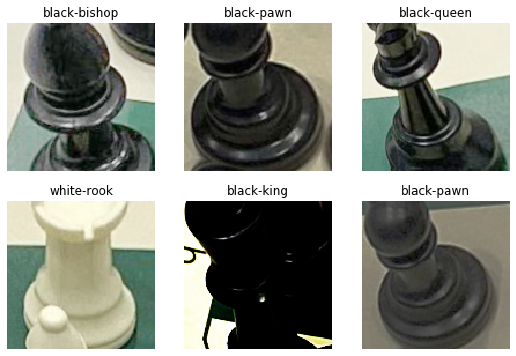

In [5]:
train_dl.show_batch(max_n=6)

##### Extract the tfms from the DL

In [6]:
train_dl.after_item

Pipeline: Resize -> ToTensor

In [7]:
train_dl.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

In [8]:
train_dl.before_batch

Pipeline: 

In [9]:
#train_dl.before_item

##### Build the DataBlock, Dataset -> WeightedDL

In [10]:
def my_piece_class_parse(e):
    return piece_class_parse(e.name)

In [11]:
train_db = DataBlock(
                blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = my_piece_class_parse,
                item_tfms = Crop,
                batch_tfms = aug_transforms(),
                dl_type = WeightedDL
            )

In [12]:
# also_works = train_db.dataloaders(train_path, )

In [13]:
train_ds = train_dl.dataset

In [14]:
train_ds = train_db.datasets(train_path)

In [15]:
wgts = [1 for e in train_dl[0].items]

In [16]:
def item_wgt(it):
    return 10 if 'queen' in it.name else 1

wgts = [item_wgt(it) for it in train_ds.train.items ]

In [17]:
train_wdl = train_ds.weighted_dataloaders(
                        
                        wgts=wgts,
                        bs=42,
                        after_item = Pipeline([
                                                Crop,
                                                ToTensor()
                                                ]),
                        after_batch = train_dl.after_batch, 
                                )

In [18]:
train_dl.after_item, train_wdl.after_item

(Pipeline: Resize -> ToTensor, Pipeline: Resize -> ToTensor)

In [19]:
train_dl.after_batch, train_wdl.after_batch

(Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm,
 Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm)

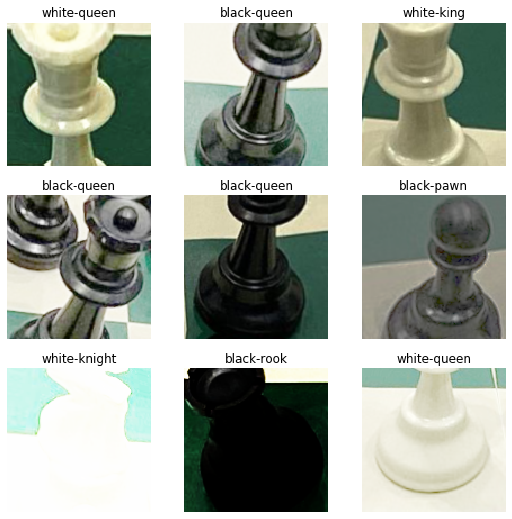

In [20]:
train_wdl.show_batch(max_n=9)

##### Test adding it to a learner

In [21]:
learn = cnn_learner(train_wdl, resnet18, )

In [22]:
learn.dls[1]

In [23]:
from modules.learnutils import learner_add_testset_2

In [24]:
_test_path = Path('../../../other-chess-data/regulation-test-2-all/')

In [25]:
learner_add_testset_2(learn, _test_path, )

In [26]:
learn.dls[0]

In [27]:
x,y = learn.dls[2].one_batch()

In [28]:
y

TensorCategory([ 7,  5,  2,  8,  9,  3,  6, 11, 10,  0,  4,  1,  7,  5,  9,  8,  3,  6,
        11, 10,  0,  4,  1,  2,  5,  7,  9,  8,  3,  6, 11, 10,  0,  4,  1,  2,
         4,  5,  7,  2,  1,  0])

In [29]:
x,y = learn.dls[1].one_batch()

In [30]:
y

TensorCategory([10,  8,  4, 10,  3, 11,  3,  4,  9,  9,  5,  9,  3,  3,  0, 11,  9,  0,
        11,  3,  4,  0,  9,  6,  2,  9,  9,  3, 11,  8,  8, 11,  2,  3,  9,  1,
         2,  0,  1,  3,  0, 10])

### Use exp_run to build it

In [33]:
%load_ext autoreload
%autoreload 2

In [34]:
from modules.expbuilder import run_exp, default_params

In [46]:
def my_weight_func(it_path):
    return 100 if 'queen' in it_path.name else 1

In [47]:
# default_params
my_params = {'_weighted_dl': True, '_weight_func': my_weight_func}

In [48]:
default_params.update(my_params)

In [49]:
dl, l = run_exp(default_params, 'dummy', b_ret=True,)

In [54]:
x, y = l.dls[0].one_batch()
y

TensorCategory([10, 10, 10,  4,  4, 10,  4,  4, 10,  4, 11,  4, 10,  4,  4,  4, 10,  4,
        10, 10,  4,  4,  4,  4,  8,  9, 10, 10,  4,  8, 10,  4])